In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from  matplotlib.colors import LinearSegmentedColormap
import pandas as pd
import seaborn as sn
import sys
from pathlib import Path
from tqdm import tqdm
import scipy
import os

import torch.nn as nn
from torch import Tensor
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from scipy.stats import wasserstein_distance
from sklearn.metrics import roc_auc_score as roc_auc_score
from scipy.special import kl_div as kl_div
from sklearn.metrics import log_loss as log_loss
from torchmetrics.classification import BinaryCalibrationError

# import custom functions from src folder
module_path = str(Path.cwd() / "../../../src")

if module_path not in sys.path:
    sys.path.append(module_path)

from SequentialNet import SequentialNet
from machine_learning import *
from util import *

In [2]:
def word_to_int(df):
    # Red = 0, blue = 1
    df["class"] = 0
    df_copy = df.copy()
    mask = df_copy["color"] == "blue"
    df.loc[mask, "class"] = 1
    return df


In [3]:
def predict_MCD(model, df, test_dataset, device, n_MC:int = 100):
     # Predict with just model
    df_new = df.copy()
    truth, logits = predict_classifier(model, test_dataset, 2, 100, device)
    preds = torch.argmax(logits, dim=-1).flatten()
    df_new["Prediction"] = preds

    #Get softmax score for blue
    df_new["Confidence"] = torch.softmax(logits, dim=-1)[:,1]

    # Predict with MC dropout
    mean_val, variance_val = mc_predictions(model, test_dataset, 2**8, n_MC, 2, len(test_dataset))
    df_new["Prediction_MC"] = np.argmax(mean_val, axis=-1).flatten()
    df_new["Confidence_MC"] = mean_val[:,-1]
    # Error is the same for both scores
    df_new["Std_MC"] = np.sqrt(variance_val[:,0])
    return df_new

In [4]:
# Set up device
device = (
    "cuda:0"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device {torch.cuda.get_device_name(0)}")

Using cuda:0 device NVIDIA TITAN V


In [13]:
# Machine learning options
x1_key = "x1"
x2_key = "x2"
n_data = [250, 500, 1000, 2000, 3000, 5000, 10000]
bs_list = [128, 128, 128*2, 128*2, 1024, 1024, 1024*2]
#n_data = [10000]
max_err_val = [0]*len(n_data)
for i in range(len(n_data)):
    if n_data[i] < 1000:
        max_err_val[i] = 0.5
    else:
        max_err_val[i] = 0.25
patience = 30
load_values = False
save_values = True

#Data constants
shapes = [2, 4]
scales = [3, 3]
k = len(scales) # Number of classes
d = 2 # Number of dimensions
p_c = [1/len(shapes)]*len(shapes) # Uniform distributon over classes

tag = f'k_{k}_d{d}_shapes{shapes}_scales{scales}_pc{p_c}'.replace(" ", "")

# Read files
train_n = 50000
trainfile = f"train_n_{train_n}_{tag}"
valfile = f"val_n_5000_{tag}"
testfile = f"test_n_10000_{tag}"
gridfile = f"grid_x1_x2_10000_{tag}"

train_data = pd.read_csv(f"../data/{trainfile}.csv")
val_data = pd.read_csv(f"../data/{valfile}.csv")
test_data = pd.read_csv(f"../data/{testfile}.csv")
grid_data = pd.read_csv(f"../data/{gridfile}.csv")
grid_rmax = grid_data["x1"].max()

X_train = torch.Tensor(np.dstack((train_data[x1_key], train_data[x2_key]))).to(torch.float32)[0]
Y_train = label_maker(train_data["class"], 2)

X_val = torch.Tensor(np.dstack((val_data[x1_key], val_data[x2_key]))).to(torch.float32)[0]
Y_val = label_maker(val_data["class"], 2)

X_test = torch.Tensor(np.dstack((test_data[x1_key], test_data[x2_key]))).to(torch.float32)[0]
Y_test = label_maker(test_data["class"], 2)

X_grid = torch.Tensor(np.dstack((grid_data[x1_key], grid_data[x2_key]))).to(torch.float32)[0]
Y_grid = torch.zeros(X_grid.shape)

In [6]:
# Create datasets for pytorch
val_dataset = torch.utils.data.TensorDataset(X_val, Y_val)
test_dataset = torch.utils.data.TensorDataset(X_test, Y_test)
grid_dataset = torch.utils.data.TensorDataset(X_grid, Y_grid)

 18%|█▊        | 46/250 [01:11<05:19,  1.56s/it]


Stopping training early at epoch 46


100%|██████████| 50/50 [00:00<00:00, 139.24it/s]


Starting MC dropout inference: 


100%|██████████| 20/20 [00:03<00:00,  6.53it/s]


n_train = 5000, logloss=0.5331892830687374, ECE= 0.02693304605782032


<Axes: xlabel='Iteration'>

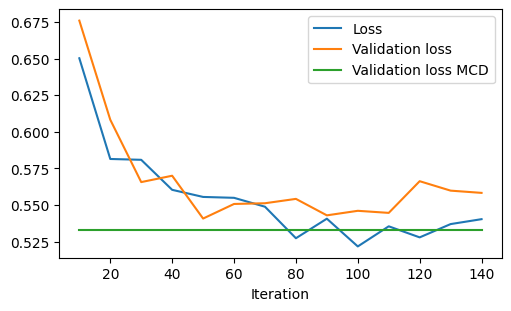

In [7]:
n_train = 5000
max_err_val=0.5
drop_out_rate = 0.3
n_MC=100
patience = 30
batchsize = 1024*2

# Create datasets for pytorch
train_dataset = torch.utils.data.TensorDataset(X_train[0:n_train], Y_train[0:n_train])

# Create model
model = SequentialNet(L=200, n_hidden=5, activation="relu", in_channels=2, out_channels=2, p=drop_out_rate).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Train model
train_results = train_classifier(model, train_dataset, 
                        val_dataset, batchsize=batchsize, epochs = 250, 
                        device = device, optimizer = optimizer, early_stopping=patience, mcd=True)
# Predict on val set
val_df = predict_MCD(model, val_data, val_dataset, device, n_MC=20)
ll = log_loss(val_df["class"], val_df["Confidence_MC"])
train_results["Validation loss MCD"] = ll
preds = torch.Tensor(val_df["Confidence_MC"])
target = torch.Tensor(val_df["class"])
bce_l1 = BinaryCalibrationError(n_bins=15, norm='l1')
ece = bce_l1(preds, target).item()
print(f"n_train = {n_train}, logloss={ll}, ECE= {ece}")

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (5, 3), layout="constrained")
train_results.plot("Iteration", ["Loss", "Validation loss", "Validation loss MCD"], ax=ax)
#ax.set_ylim(0, 2)


In [8]:
test_df = predict_MCD(model, test_data, test_dataset, device, n_MC=n_MC)
grid_df = predict_MCD(model, grid_data, grid_dataset, device, n_MC=n_MC)

100%|██████████| 100/100 [00:00<00:00, 287.48it/s]


Starting MC dropout inference: 


100%|██████████| 100/100 [00:00<00:00, 474.68it/s]


Starting MC dropout inference: 


100%|██████████| 100/100 [00:26<00:00,  3.81it/s]


Text(0.5, 0.98, 'Number of training datapoints: 5000. Drop out rate: 0.3')

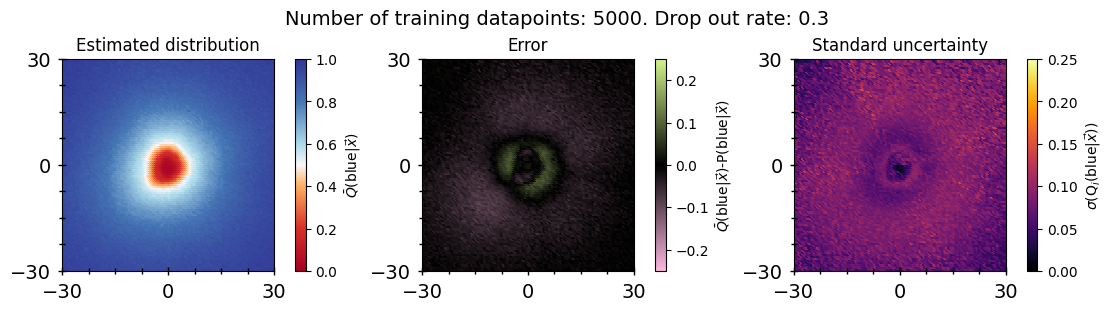

In [14]:
max_err_val=0.25
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (11,3), layout="constrained")
axs[0] = plot_results(grid_df, "Confidence_MC", axs[0], "Estimated distribution", grid=True, rmax=grid_rmax)
hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False)
fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=red_blue_cmap()), fraction=0.050, pad=0.04, 
                label=r"$\bar{Q}$(blue|$\vec{x}$)", ax=axs[0])

axs[1] = plot_diff(grid_df, grid_df, "Confidence_MC", "p_c1_given_r", axs[1], r"Error", max_val = max_err_val, rmax=grid_rmax)
hue_norm = mpl.colors.Normalize(vmin=-max_err_val, vmax=max_err_val, clip=False)
fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=pink_black_green_cmap()), fraction=0.050, pad=0.04, 
                label=r"$\bar{Q}$(blue|$\vec{x}$)-P(blue|$\vec{x}$)", ax=axs[1])

axs[2] = plot_std(grid_df, "Std_MC", axs[2], "Standard uncertainty", grid=True, max_val = max_err_val, rmax=grid_rmax)

hue_norm = mpl.colors.Normalize(vmin=0, vmax=max_err_val, clip=False)
fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap="inferno"), fraction=0.050, pad=0.04, 
                label=r"$\sigma$(Q$_i$(blue|$\vec{x}$))", ax=axs[2])

#fig.savefig(f"../fig/MCD_ntrain_{n_train}.pdf", format="pdf", bbox_inches='tight', dpi=350)
fig.suptitle(f"Number of training datapoints: {n_train}. Drop out rate: {drop_out_rate}", fontsize=14)

Text(0.5, 0.98, 'Number of datapoints: 5000. Dropout rate: 0.3')

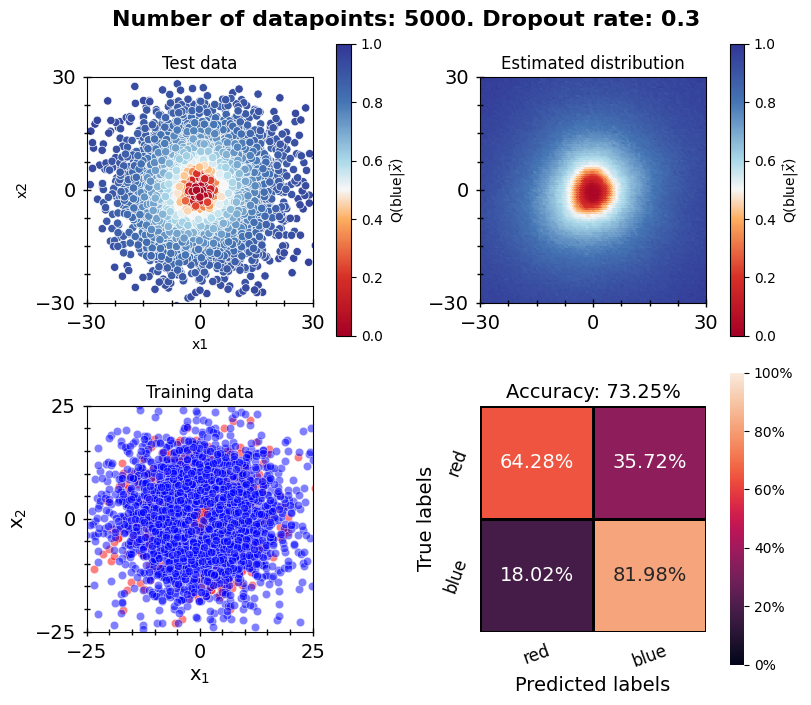

In [15]:
fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (8, 7), layout="constrained")

axs[0][0] = plot_results(test_df, "Confidence_MC", axs[0][0], "Test data", rmax=grid_rmax)
axs[0][1] = plot_results(grid_df, "Confidence_MC", axs[0][1], "Estimated distribution", grid=True, rmax=grid_rmax)
axs[1][1] = plot_conf_matrix(test_df, "class", "Prediction_MC", ["red", "blue"], axs[1][1])
axs[1][0] = plot_data(train_data[0:n_train], axs[1][0], "Training data")

cmap = red_blue_cmap()
hue_norm = mpl.colors.Normalize(vmin=0, vmax=1, clip=False)
fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r"Q(blue|$\vec{x}$)", ax=axs[0][0])
fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm, cmap=cmap), label=r"Q(blue|$\vec{x}$)", ax=axs[0][1])

fig.suptitle(f"Number of datapoints: {n_train}. Dropout rate: {drop_out_rate}", size=16, fontweight="bold")

Text(0.5, 0.98, 'Number of training data: 5000. Grid test points.')

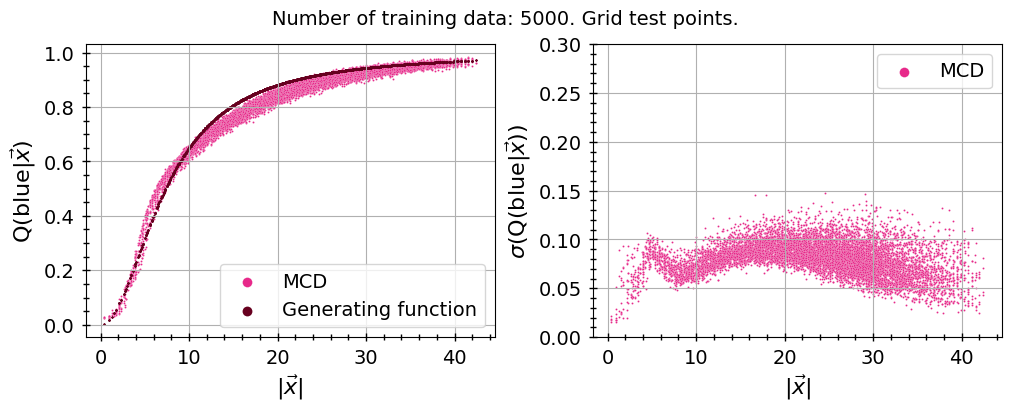

In [16]:

fig, axs = plt.subplots(nrows=1, ncols=2, figsize= (10, 4), layout="constrained")
sn.scatterplot(grid_df, x="r", y="Confidence_MC", s=2, ax = axs[0], label="MCD", color="#e7298a")
#sn.lineplot(truth_data, x="r_x", y="P_blue_given_x", linewidth=2, ax = axs[0], label="Generating function", color="#67001f")
sn.scatterplot(grid_df, x="r", y="p_c1_given_r", s=2, ax = axs[0], label="Generating function", color="#67001f", linewidth=0)
axs[0].set_ylabel(r"Q(blue|$\vec{x}$)", fontsize=16)

sn.scatterplot(grid_df, x="r", y="Std_MC", s=2, ax = axs[1], label="MCD", color="#e7298a")
axs[1].set_ylabel(r"$\sigma$(Q(blue|$\vec{x}$))", fontsize=16)
axs[1].set_ylim(0, 0.3)

for ax in axs:
    ax.legend(markerscale=5, fontsize=14)
    ax.set_xlabel(r"$|\vec{x}|$", fontsize=16)
    #ax.set_xlim(0, grid_rmax)
    ax.tick_params(which="both", direction="inout", bottom=True, left=True, labelsize=14, pad=5, length=4, width=1)
    ax.tick_params(which="major", length=6)
    ax.minorticks_on()
    ax.grid()
fig.suptitle(f"Number of training data: {n_train}. Grid test points.", fontsize=14)

Text(0.5, 0.98, 'Number of training data: 5000. Test set.')

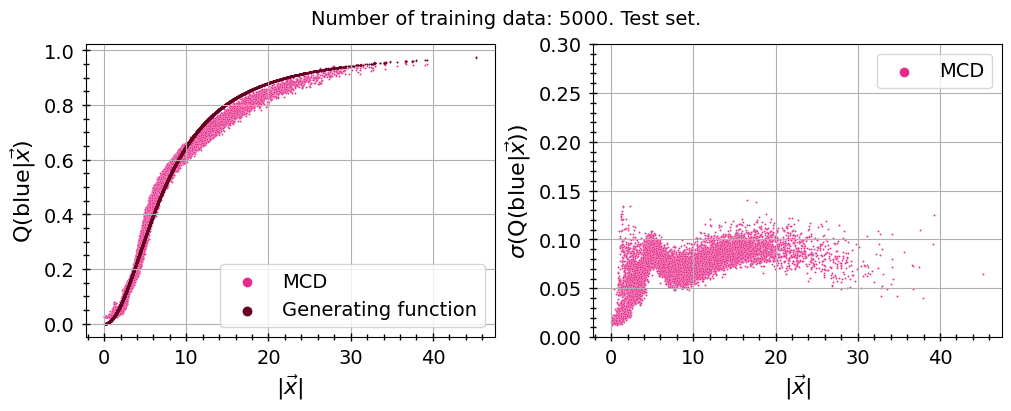

In [17]:

fig, axs = plt.subplots(nrows=1, ncols=2, figsize= (10, 4), layout="constrained")
sn.scatterplot(test_df, x="r", y="Confidence_MC", s=2, ax = axs[0], label="MCD", color="#e7298a")
#sn.lineplot(truth_data, x="r_x", y="P_blue_given_x", linewidth=2, ax = axs[0], label="Generating function", color="#67001f")
sn.scatterplot(test_df, x="r", y="p_c1_given_r", s=2, ax = axs[0], label="Generating function", color="#67001f", linewidth=0)
axs[0].set_ylabel(r"Q(blue|$\vec{x}$)", fontsize=16)

sn.scatterplot(test_df, x="r", y="Std_MC", s=2, ax = axs[1], label="MCD", color="#e7298a")
axs[1].set_ylabel(r"$\sigma$(Q(blue|$\vec{x}$))", fontsize=16)
axs[1].set_ylim(0, 0.3)

for ax in axs:
    ax.legend(markerscale=5, fontsize=14)
    ax.set_xlabel(r"$|\vec{x}|$", fontsize=16)
    #ax.set_xlim(0, grid_rmax)
    ax.tick_params(which="both", direction="inout", bottom=True, left=True, labelsize=14, pad=5, length=4, width=1)
    ax.tick_params(which="major", length=6)
    ax.minorticks_on()
    ax.grid()
fig.suptitle(f"Number of training data: {n_train}. Test set.", fontsize=14)